In [2]:

import numpy as np
import matplotlib.pyplot as plt
import h5py

import PSID
from PSID.evaluation import evalPrediction
# from PSID.MatHelper import loadmat

def eval_model(data,predictions,mask=None):
  if mask is None:
    mask = np.ones(data['valid_behavior'][:].shape[0],dtype=bool)

  # PSID_R2 = evalPrediction(data['valid_behavior'][:][mask].reshape((-1,2)), predictions[mask].reshape(-1,2), 'R2').mean()

  directions = data['valid_target_direction']
  unique_dirs = sorted(set(directions))

  R2 = np.empty((len(unique_dirs))) # directions
  for i,d in enumerate(unique_dirs):
    precision_error = (predictions[mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)])**2
    total_variance = (data['valid_behavior'][:][mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)].mean(0))**2+1e-6
    R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  R_UIVE = R2.mean() #uninstructed variance explained

  precision_error = (predictions[mask] - data['valid_behavior'][:][mask])**2
  total_variance = (data['valid_behavior'][:][mask] - data['valid_behavior'][:][mask].mean(0))**2
  vec_R2 = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  return vec_R2,R_UIVE

Matplotlib created a temporary cache directory at /tmp/matplotlib-pn2chf8m because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
data = h5py.File("../datasets/Chewie_CO_FF_2016-10-07_session_vel_M1_spikes_go.h5", "r")
print(data.keys())
print(data["valid_recon_data"].shape)

<KeysViewHDF5 ['train_behavior', 'train_encod_data', 'train_epoch', 'train_inds', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_encod_data', 'valid_epoch', 'valid_inds', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(116, 101, 70)


In [ ]:
np.arange(10)[None]

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [238]:
# PSID(neural, behaviour, latents dimensions,
# latent states to extract in the first stage,
# future and past horizon)

# run here with 40 dim, where there are some oscillations
n_factors = 40
n_beh_factors = 0
# mask = np.ones_like(data['train_epoch'],dtype=bool) # train on all epochs
mask = data['train_epoch'][:] == 1 # train on the AD epoch only
model = PSID.PSID(
    [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
    n_factors, n_beh_factors, 10
)

## Scan R2 with respect to the number of behavioral factors

In [230]:
n_factors = 20

performance = []
for n_beh_factors in range(2,1+n_factors//2):
    mask = np.ones_like(data['train_epoch'],dtype=bool) # train on all epochs
    # mask = data['train_epoch'][:] == 1 # train on the AD epoch only
    model = PSID.PSID(
        [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
        n_factors, n_beh_factors, 10 
    )
    #max(10, int(np.ceil(n_beh_factors/2))

    predictions = []
    for trial in range(data['valid_recon_data'].shape[0]):
        predictions.append(model.predict(data['valid_recon_data'][trial])[0])
    predictions = np.array(predictions)

    R2s = []
    for mask in ([None] + [data['valid_epoch'][:] == i for i in [0,1,2]]):
        R2 = eval_model(data,predictions,mask=mask)
        print(n_beh_factors,R2)
        R2s.append(R2)
    performance.append(R2s)

performance = np.array(performance)



2 (0.6574247257033319, -1.494366853082918)
2 (0.6815993991584233, -1796852.4328255246)
2 (0.655162768048871, -2274757.8555155653)
2 (0.620365216738098, -4091657.9380844748)
3 (0.7164042925864601, -1.0765548119882022)
3 (0.7505722159264746, -1760009.3511334162)
3 (0.6785798161247181, -2843329.687029264)
3 (0.7012141572765995, -4149761.546776231)
4 (0.7386547945497264, -0.8904591074959616)
4 (0.7675599209557218, -1507716.7124680586)
4 (0.7006144517638846, -2648507.786009733)
4 (0.7295671827013609, -3351742.0352029027)
5 (0.7392519765708674, -0.8689313239009733)
5 (0.7651479363158171, -1279233.1247648387)
5 (0.7114695585418229, -2383727.130716577)
5 (0.7248237127928969, -3033872.9388046223)
6 (0.7373038772247615, -0.8898713799257282)
6 (0.7684010367548302, -1153716.3587189603)
6 (0.7229601719282083, -2185296.304179377)
6 (0.7073098966010383, -2705649.4949006275)
7 (0.7577922746915323, -0.733855481437159)
7 (0.7856966562701619, -1320358.3826762338)
7 (0.7477171009865762, -2186572.976391781

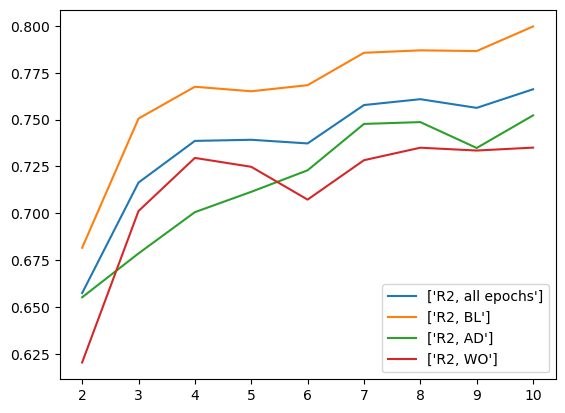

In [234]:
# plt.plot(np.arange(2,1+n_factors/2),performance[:,0,2],label=["R_UIVE, all epochs"])
fs = np.arange(2,1+n_factors/2)
plt.plot(fs,performance[:,0,0],label=["R2, all epochs"])
plt.plot(fs,performance[:,1,0],label=["R2, BL"])
plt.plot(fs,performance[:,2,0],label=["R2, AD"])
plt.plot(fs,performance[:,3,0],label=["R2, WO"])
plt.legend()

## Back to analysing a single model

In [239]:
#predict factors
train_predictions = []
for trial in range(data['train_recon_data'].shape[0]):
    train_predictions.append(model.predict(data['train_recon_data'][trial])[2])

train_predictions = np.array(train_predictions)

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[2])

predictions = np.array(predictions)

# train ridge regression to predict behavior from factors
from sklearn.linear_model import Ridge
X_train = train_predictions.reshape(-1,train_predictions.shape[-1])
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions.reshape(-1,predictions.shape[-1])
ridge = Ridge(alpha=1).fit(X_train, Y_train)
Y_pred = ridge.predict(X_test).reshape(data['valid_behavior'].shape)

X_train = train_predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
rel_ridge = Ridge(alpha=1).fit(X_train, Y_train)
rel_Y_pred = rel_ridge.predict(X_test).reshape(data['valid_behavior'].shape)

ValueError: cannot reshape array of size 0 into shape (0)

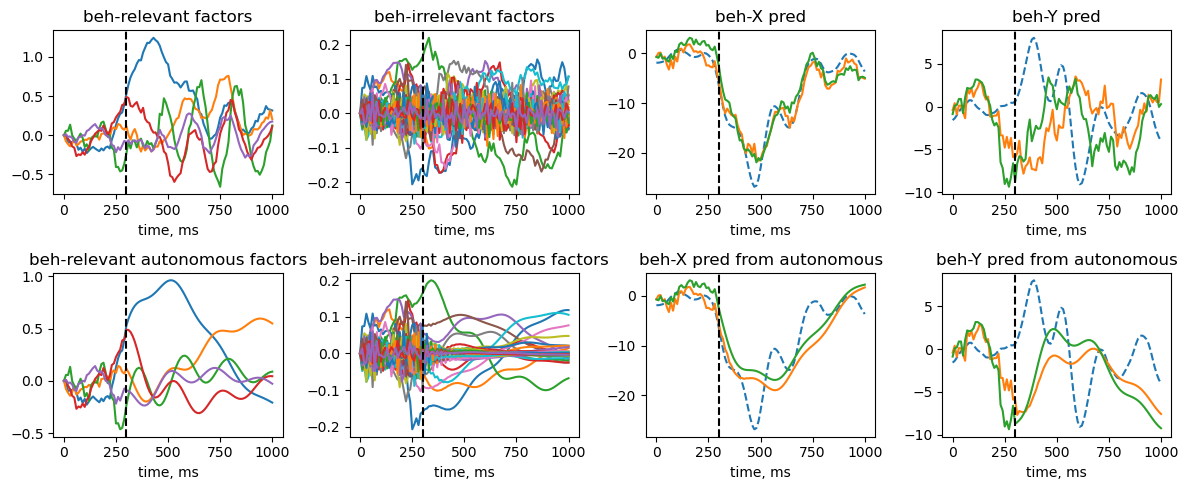

In [ ]:

fig, axes = plt.subplots(2,4, figsize=(12,5))
trial = 5
axes[0,0].set_title('beh-relevant factors')
axes[0,0].plot(predictions[trial,:,:n_beh_factors])
axes[0,1].set_title('beh-irrelevant factors')
axes[0,1].plot(predictions[trial,:,n_beh_factors:])
axes[0,2].set_title('beh-X pred')
axes[0,2].plot(data['valid_behavior'][trial,:,0],linestyle='--')
axes[0,2].plot(Y_pred[trial,:,0])
axes[0,2].plot(rel_Y_pred[trial,:,0])
axes[0,3].set_title('beh-Y pred')
axes[0,3].plot(data['valid_behavior'][trial,:,1],linestyle='--')
axes[0,3].plot(Y_pred[trial,:,1])
axes[0,3].plot(rel_Y_pred[trial,:,1])

st = 30
trajectories = np.zeros_like(predictions)
trajectories[:,st] = predictions[:,st]
for i in range(st+1, trajectories.shape[1]):
    trajectories[:,i] = (model.A @ trajectories[:,i-1].T).T # transposes deal with trial dimension, tested
trajectories[:,:st] = predictions[:,:st]
axes[1,0].set_title('beh-relevant autonomous factors')
axes[1,0].plot(trajectories[trial,:,:n_beh_factors])
axes[1,1].set_title('beh-irrelevant autonomous factors')
axes[1,1].plot(trajectories[trial,:,n_beh_factors:])

Y_autonomous_pred = ridge.predict(trajectories.reshape(-1,trajectories.shape[-1])).reshape(data['valid_behavior'].shape)
rel_Y_autonomous_pred = rel_ridge.predict(trajectories[...,:n_beh_factors].reshape(-1,n_beh_factors)).reshape(data['valid_behavior'].shape)
axes[1,2].set_title('beh-X pred from autonomous')
axes[1,2].plot(data['valid_behavior'][trial,:,0],linestyle='--')
axes[1,2].plot(Y_autonomous_pred[trial,:,0])
axes[1,2].plot(rel_Y_autonomous_pred[trial,:,0])
axes[1,3].set_title('beh-Y pred from autonomous')
axes[1,3].plot(data['valid_behavior'][trial,:,1],linestyle='--')
axes[1,3].plot(Y_autonomous_pred[trial,:,1])
axes[1,3].plot(rel_Y_autonomous_pred[trial,:,1])

for ax in axes.flatten():
    ax.axvline(st, color='k', linestyle='--')
    ax.set_xlabel('time, ms')
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels([0,250,500,750,1000])

plt.tight_layout()

In [153]:
data['valid_epoch'][:]

array([1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0,
       2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0,
       2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 2, 0,
       0, 0, 0, 1, 2, 0])

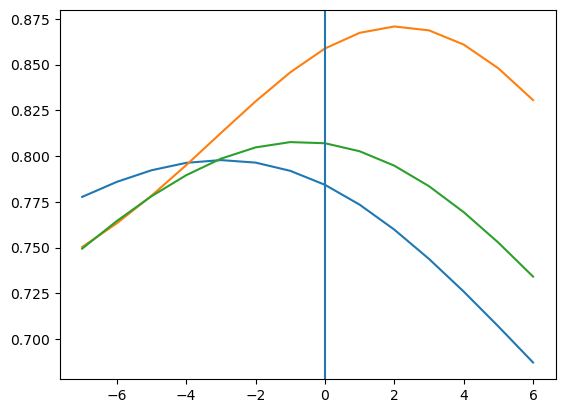

In [154]:
lags = range(-7,7)
for epoch in [0,1,2]:
    c = []
    for lag in lags:
        beh = np.roll(data['valid_behavior'],lag,axis=1)
        mask = data['valid_epoch'][:] == epoch
        c.append(np.corrcoef(beh[mask][:,st:].flatten(),Y_pred[mask][:,st:].flatten())[0,1])
    plt.plot(lags,c)
plt.axvline(0)

(0.4811621088248593,
 array([-2.10174653, -1.42790456, -1.66158888, -5.32812243, -1.85078981,
        -2.13457109, -4.28906472, -1.48996699]),
 -2.5354693755801154)

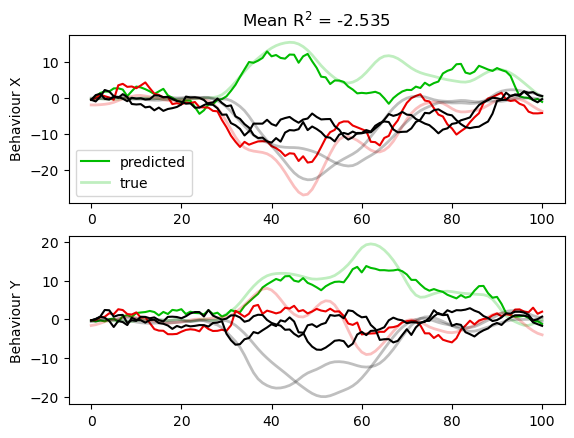

In [240]:
colors = plt.cm.nipy_spectral(np.arange(8)/8)

directions = data['valid_target_direction']
unique_dirs = sorted(set(directions))
direction_index = [unique_dirs.index(i) for i in directions]

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[0])
predictions = np.array(predictions)

R2 = np.empty((len(unique_dirs))) # directions
for i,d in enumerate(unique_dirs):
  precision_error = (predictions[directions==d] - data['valid_behavior'][directions==d])**2
  total_variance = (data['valid_behavior'][:][directions==d] - data['valid_behavior'][directions==d].mean(0))**2+1e-6
  R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space

precision_error = (predictions - data['valid_behavior'][:])**2
total_variance = (data['valid_behavior'][:] - data['valid_behavior'][:].mean(0))**2+1e-6
R2_all = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space

for trial in range(4,8):
    b = data['valid_behavior'][trial]
    p = predictions[trial]
    plt.subplot(2,1,1)
    plt.plot(p[:,0],'-', c=colors[direction_index[trial]], label='predicted')
    plt.plot(b[:,0], '-', c=colors[direction_index[trial]], alpha= 0.25, lw=2, label='true')
    plt.subplot(2,1,2)
    plt.plot(p[:,1],'-', c=colors[direction_index[trial]])
    plt.plot(b[:,1], '-', c=colors[direction_index[trial]], alpha= 0.25, lw=2) 
plt.subplot(2,1,1)
plt.ylabel('Behaviour X')
plt.title(f'Mean R$^2$ = {R2.mean():.3f}')
plt.legend(['predicted', 'true'])
plt.subplot(2,1,2)
plt.ylabel('Behaviour Y')
    
R2_all, R2, R2.mean()

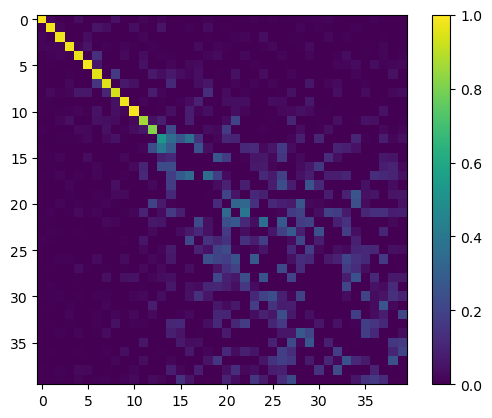

In [241]:
plt.imshow(model.A, vmin=0, vmax=1)
plt.colorbar()

191.51768781069373 0.952124697867372 [-7.00059969e-02-0.10602526j -7.00059969e-02+0.10602526j
 -1.15783366e-01-0.07409965j -1.15783366e-01+0.07409965j
 -1.42459880e-01+0.02297566j -1.42459880e-01-0.02297566j
  5.57039698e-05+0.j          1.91987822e-01-0.10823501j
  1.91987822e-01+0.10823501j  1.47728143e-01-0.15154836j
  1.47728143e-01+0.15154836j  1.06941379e-01+0.17545222j
  1.06941379e-01-0.17545222j -7.88675166e-02+0.j
  1.06346989e-01-0.0420806j   1.06346989e-01+0.0420806j
 -4.30258843e-02+0.j         -9.34472653e-02+0.092239j
 -9.34472653e-02-0.092239j   -2.00027289e-01+0.j
 -7.77648114e-02+0.03459508j -7.77648114e-02-0.03459508j
 -8.31365354e-02+0.j         -5.31230157e-02+0.j
  4.59483361e-02+0.00258145j  4.59483361e-02-0.00258145j
  1.77960834e-01+0.14135645j  1.77960834e-01-0.14135645j
 -1.14214173e-01-0.0029178j  -1.14214173e-01+0.0029178j
 -4.83999097e-03+0.26936039j -4.83999097e-03-0.26936039j
 -6.44021292e-02+0.j          1.07997170e-02-0.03659047j
  1.07997170e-02+0.036

(-1.1003474046529553, 1.1072954977120637, -1.1, 1.1)

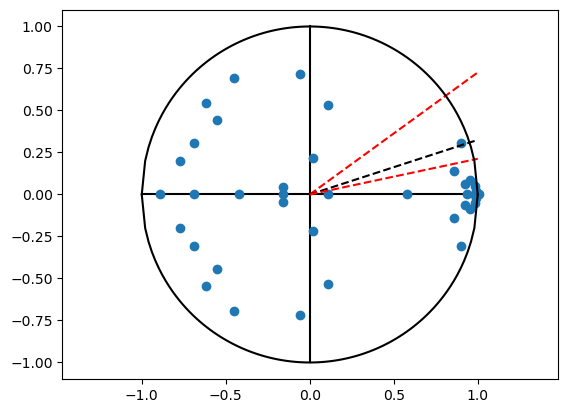

In [243]:
evals, evecs = np.linalg.eig(model.A)

plt.plot([-1,1],[0,0],'k')
plt.plot([0,0],[-1,1],'k')
plt.plot(evals.real,evals.imag,'o')
# for ev in evals:
#     plt.plot([0,ev.real],[0,ev.imag],'o')
# draw a line at 18 degrees
plt.plot([0,1],[0,np.tan(2 * 10 * np.pi/100)],'r--')
plt.plot([0,1],[0,np.tan(2 * 10 * np.pi/200)],'k--')
plt.plot([0,1],[0,np.tan(2 * 10 * np.pi/300)],'r--')
# draw a unit circle
x = np.linspace(-1,1,100)
y = np.sqrt(1-x**2)
plt.plot(x,y,'k')
y = -np.sqrt(1-x**2)
plt.plot(x,y,'k')

for eval, evec in zip(evals,evecs):
    a = np.angle(eval)
    if (a > 2 * 10 * np.pi/300) & (a < 2 * 10 * np.pi/100):
        T = 2 * 10 * np.pi / a
        amp = np.linalg.norm(eval)
        print(T,amp,evec)

plt.axis('equal')

In [6]:
# Fs = [10,14,18,22,26,30,34,38,42]
Fs = [2,3,4,5,6,7,8,9]
eigenvalues = np.empty((len(Fs),4), dtype=object)
potentially_oscillatory_eigenvalues = np.empty((len(Fs),4), dtype=object)
for i, n_factors in enumerate(Fs):

    for j,n_beh_factors in enumerate([0]):

        if eigenvalues[i,j] is None:
            
            print('Running with', n_beh_factors, '/', n_factors, 'factors')
            mask = data['train_epoch'][:] == 1 # train on the AD epoch only
            model = PSID.PSID(
                [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
                n_factors, n_beh_factors, max(10, int(np.ceil(n_beh_factors/2)))
            )

            evals = np.linalg.eig(model.A)[0]

            interesting_evals = []
            for eval in evals:
                a = np.angle(eval)
                if (a > 2 * 10 * np.pi/300) & (a < 2 * 10 * np.pi/100):
                    T = 2 * 10 * np.pi / a
                    amp = np.linalg.norm(eval)
                    print(T,amp)
                    interesting_evals.append(eval)

            eigenvalues[i,j] = evals
            potentially_oscillatory_eigenvalues[i,j] = interesting_evals
        

Running with 0 / 2 factors
Running with 0 / 3 factors
Running with 0 / 4 factors
Running with 0 / 5 factors
Running with 0 / 6 factors
Running with 0 / 7 factors
Running with 0 / 8 factors
Running with 0 / 9 factors
223.27735635956975 0.9586703484550172


In [ ]:
np.save('eigenvalues.npy', eigenvalues)
np.save('potentially_oscillatory_eigenvalues.npy', potentially_oscillatory_eigenvalues)

In [235]:
eigenvalues = np.load('eigenvalues.npy', allow_pickle=True)
potentially_oscillatory_eigenvalues = np.load('potentially_oscillatory_eigenvalues.npy', allow_pickle=True)


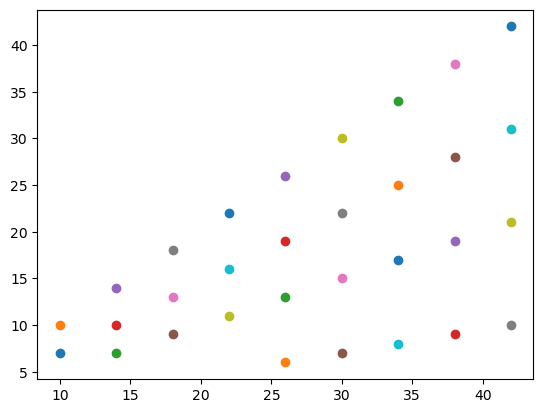

In [236]:
for i, n_factors in enumerate(Fs):

    for j,n_beh_factors in enumerate([n_factors//4, n_factors//2, (n_factors*3)//4, n_factors]):

        if len(potentially_oscillatory_eigenvalues[i,j])>0:
            plt.scatter(n_factors,n_beh_factors)